# Lab 1 Signal Processing

## Import Library and Data

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import solve_toeplitz
from scipy.optimize import minimize


data = pd.read_csv('qbo.txt', delimiter = "  ", names = ["Serie 1", "Serie 2", "Serie 3"], engine='python')

In [73]:
serie = data["Serie 1"]

In [181]:
## Train / Test
n = len(serie)
n_train = int(0.7*n)

In [182]:
serie_train = serie[:n_train]
serie_test = serie[n_train:]

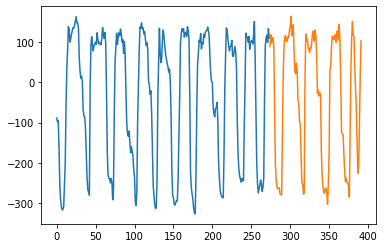

In [183]:
plt.plot(serie_train)
plt.plot(serie_test)

## Auto-Regressive Model

In [208]:
def build_embedding_matrix(p, serie):
    """Build the embedding matrix
    
    Args:
        p (int) : number of lag
        serie (array like) : serie to regress
    
    Returns:
        Embedding Matrix
    """
    
    
    n = len(serie)
    
    matrix = np.zeros((n - p, p))
    
    for i in range(p):
        matrix[:, i] = serie[(p-i-1):(n - i -1)]
        
    return matrix

def build_autocorrelation(p, serie, full_matrix = True):
    """Build the autocorrelation vector and matrix
    
    Args:
        p (int) : number of lag
        serie (array like) : serie to regress
    
    Returns:
        Vector of p autocorrelation 1-p
        Embedding Matrix
    """
    
    vector_autocorrelation = np.array([serie.autocorr(lag = i) for i in range(1, p + 1)])
    
    if not full_matrix:
        return vector_autocorrelation
    
    matrix = np.zeros((p, p))
    matrix[np.arange(p), np.arange(p)] = 1.
    
    for i in range(1, p):        
        matrix[np.arange(p - i), np.arange(p - i) + i] = vector_autocorrelation[i - 1]
        matrix[np.arange(p - i) + i, np.arange(p - i)] = vector_autocorrelation[i - 1]
    
    return vector_autocorrelation, matrix

def prediction(coefficient, serie_train, serie_test):
    p, n1, n2 = len(coefficient), len(serie_train), len(serie_test)
    predict_values = np.zeros(n1 + n2)
    
    predict_values[:n1] = serie[:n1]
    
    for i in range(n1, n1 + n2):
        predict_values[i] = coefficient.dot(predict_values[(i-p):i][::-1])
    
    return predict_values

def predictive_error(p, predict_values, serie_train):
    n1 = len(serie_train)
    return np.sqrt(np.mean((predict_values[n1:] - serie[n1:])**2))

In [261]:
## Least Square Solution
p = 50 ## Lag Number

target = serie_train[p:]
embedding = build_embedding_matrix(p, serie_train)

# Compute Solution
a_estimate = np.linalg.solve(embedding.T.dot(embedding), embedding.T.dot(target))

print(a_estimate)

[ 1.44589896 -0.55733612 -0.19860168  0.3022342  -0.13738337 -0.02261678
  0.01819974 -0.05361353  0.03582207 -0.06586411  0.07054705 -0.07540126
  0.04909597 -0.0895402   0.08660049  0.03835194 -0.12737435  0.02934586
  0.07291799 -0.07731936  0.00831454  0.03632021  0.05233968  0.02581461
  0.01725312 -0.00651901 -0.0428667  -0.07342623  0.14634973  0.03118737
 -0.04910368 -0.10593811  0.13539127  0.10652553 -0.2874101   0.31119504
 -0.08334827 -0.02408392  0.03818063 -0.15881317  0.06142713  0.088182
 -0.01411248 -0.0275907   0.0248132  -0.08531199  0.15450179 -0.06614445
 -0.04728165  0.02605162]


Text(0.5, 1.0, 'Error (Mean square) : 116.78210561299663')

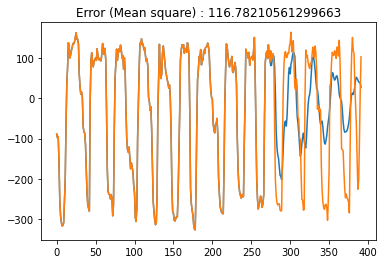

In [262]:
predict = prediction(a_estimate, serie_train, serie_test)
plt.plot(predict)
plt.plot(serie)
plt.title("Error (Mean square) : {}".format(predictive_error(p, predict, serie_train)))

[ 1.42255723 -0.54108441 -0.17971867  0.23704676 -0.05161761 -0.14978823
  0.0846699  -0.0026869  -0.05301291 -0.05645066  0.08442358 -0.11655974
  0.12308008 -0.19559181  0.16141431 -0.03441421 -0.13230138  0.08238228
  0.01692556 -0.11617015  0.02926818  0.05283258 -0.03913918  0.05470271
  0.04340899 -0.10537943 -0.00778847 -0.01335087 -0.00896382  0.12587039
 -0.05566443 -0.15783778  0.0738232   0.18598581 -0.32733186  0.26976688
 -0.05745315 -0.01142859 -0.0558511  -0.1127613   0.08440721  0.12090322
 -0.26184616  0.24595231 -0.07580731 -0.13911642  0.17025811  0.01667395
 -0.15599341  0.04744758]


Text(0.5, 1.0, 'Error (Mean square) : 148.88360686461183')

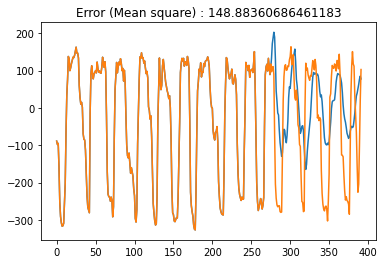

In [263]:
## Auto correlation Solution
vector_autocorrelation, auto_corr = build_autocorrelation(p, serie_train)
a_estimate_auto = np.linalg.solve(auto_corr, vector_autocorrelation)
print(a_estimate_auto)
predict = prediction(a_estimate_auto, serie_train, serie_test)
plt.plot(predict)
plt.plot(serie)
plt.title("Error (Mean square) : {}".format(predictive_error(p, predict, serie_train)))

[ 1.41834881 -0.54151236 -0.17202762  0.23096599 -0.05533907 -0.13843003
  0.07240895  0.00305655 -0.04911857 -0.06194035  0.08195809 -0.11736622
  0.12062563 -0.18320447  0.14621237 -0.02564737 -0.12908926  0.07506225
  0.01431665 -0.11044655  0.02890795  0.05231689 -0.03959787  0.04981486
  0.04557123 -0.10301584 -0.00966729 -0.01086856 -0.0075922   0.12062997
 -0.05498514 -0.15427626  0.06769823  0.1847689  -0.32039444  0.26107428
 -0.05172976 -0.01699734 -0.05196239 -0.11570022  0.08207665  0.12104825
 -0.25841053  0.23938414 -0.07843301 -0.12815764  0.16209582 -0.0090195
 -0.0886962 ]


Text(0.5, 1.0, 'Error (Mean square) : 150.1674907185055')

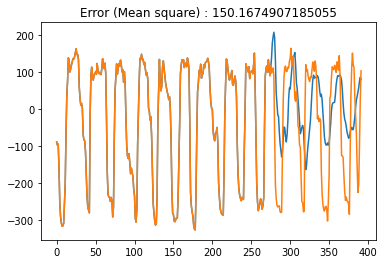

In [264]:
## Toeplitz Solver
vector_autocorrelation = build_autocorrelation(p, serie_train, full_matrix = False)
vector_autocorrelation = np.append(1, vector_autocorrelation)
a_estimate_toepliz = solve_toeplitz(vector_autocorrelation[:(p-1)], vector_autocorrelation[1:p])
print(a_estimate_toepliz)
predict = prediction(a_estimate_toepliz, serie_train, serie_test)
plt.plot(predict)
plt.plot(serie)
plt.title("Error (Mean square) : {}".format(predictive_error(p, predict, serie_train)))

In [227]:
def objective(p):
    """Objective Function to minimize, return squared error"""
    vector_autocorrelation, auto_corr = build_autocorrelation(p, serie)
    a_estimate_auto = np.linalg.solve(auto_corr, vector_autocorrelation)
    predict = prediction(a_estimate_auto, serie_train, serie_test)
    return predictive_error(p, predict, serie_train)

In [228]:
values = [objective(p) for p in range(1, 100)]

In [229]:
values

[163.46651656450754,
 157.76429661349238,
 157.8383979602591,
 157.59160461204698,
 156.5620155938658,
 155.46674430919384,
 153.696787139059,
 150.632399058258,
 149.3274917321909,
 147.40221405961302,
 144.23133695060216,
 139.5520847867948,
 136.58744133999897,
 135.02622508957296,
 135.0273323281413,
 136.00795537949415,
 137.13838774968946,
 139.67556279130554,
 140.4179964740479,
 139.39253207144574,
 132.46965155298784,
 129.2770635466045,
 128.24329095626854,
 128.82476968331852,
 128.90571854140552,
 130.83627892241287,
 130.6683592012282,
 128.51203216320584,
 128.52030275461,
 128.53484120985507,
 128.5972674216427,
 127.66775221028934,
 128.72600864730126,
 130.16924734963965,
 128.5576671135677,
 130.0768216148664,
 128.52377133782173,
 128.52719061829742,
 129.13007096633697,
 128.6242665511342,
 129.05512298885975,
 128.65711810767763,
 128.9953288802191,
 128.62243518130407,
 131.57573912194644,
 130.05823101341207,
 129.99563026372417,
 131.98746542319836,
 133.4612865

In [230]:
p = np.argmin(values)

In [231]:
p

31